In [49]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
import os
import csv
from PIL import Image

In [67]:
transform=transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1)
])

In [68]:
class SampleDataset(Dataset):
    def __init__(self, image_dir, conductivities, transform=None):
        self.conds=conductivities
        self.samples=[]
        for filename in os.listdir(image_dir):
            self.samples.append(transform(Image.open(image_dir+filename)))
        self.samples=torch.stack(tensors=self.samples)
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index):
        return self.samples[index], self.conds[index]
    
    def __to__(self, device):
        self.samples=self.samples.to(device)
        self.conds=self.conds.to(device)

In [69]:
with open('./data/data.csv') as f:
    reader=csv.reader(f)
    d=list(reader)
conductivities=torch.tensor(data=[float(x[2]) for x in d[1:]], dtype=torch.float32)
conductivities

tensor([1.0010, 1.0042, 1.0047,  ..., 1.5074, 1.5077, 1.5078])

In [70]:
dataset=SampleDataset(image_dir='./data/samples/', conductivities=conductivities, transform=transform)

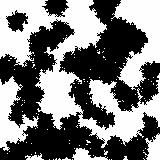

In [71]:
tensorToImageTransform=tv.transforms.ToPILImage()
tensorToImageTransform(dataset[400][0])

In [107]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_filters, image_size):
        super(CNN, self).__init__()

        #calculating image resolution as we progress through model
        image_size_1=(image_size-8+1)//2
        image_size_2=(image_size_1-4+1)//2
        print(image_size_2)
        self.conv=torch.nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=num_filters, kernel_size=(8, 8), stride=1),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=num_filters, out_channels=num_filters*2, kernel_size=(4, 4), stride=1),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(in_features=image_size_2*image_size_2*num_filters*2, out_features=150),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=150, out_features=84),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=84, out_features=1)
        )

    def forward(self, x):
        return self.conv(x)

In [109]:
model=CNN(1, 32, 160)
model(dataset[400][0].view(1, 1, 160, 160))

36


tensor([[-0.0770]], grad_fn=<AddmmBackward0>)